In [ ]:
# Exploration + Offline RL
# Implementation of Random Network Distillation (RND) to collect policy data 
# and then application of this technique to train the model using a Deep Q network.

# Compare and contrast greedy policy and RND for exploration

# RND from: https://github.com/orrivlin/MountainCar_DQN_RND

In [22]:
### MAIN #######################################################################
# The chosen environments need sparse reward for exploration to be useful 

# ENVIRONMENT SUMMARY: -> MountainCar-v0
# -> Discrete action space

# I highlighted this environment previous as one which requires a good exploration strategy 

# Observation ->  2 items
# Position scalar and velocity scalar

# Action ->  3 items
# Left, right and none

# Reward -> 1 item

#################################################################################

# TO DO: 
# 1 - set up and test DQN algorithm with greedy actions -> DONE
# 2 - implement the RND -> DONE
# 3 - Fill the replay memory
# 4 - Add conservative bound on DQN (CQL)

import os
import random
import gym
import numpy as np
from collections import deque
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.optimizers import Adam
import cv2
import pickle
import imageio

# The Neural Network for the DQN
def DQN_Model(input_shape, action_space, lr):
    X_input = Input(shape=(input_shape,))
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X_input)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X)
    model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')

    return model

# The Neural Network for the RND
def RND_Model(input_shape, lr):
    X_input = Input(shape=(input_shape,))
    
    X = Dense(128, activation="relu", kernel_initializer='he_uniform')(X_input)    
    X = Dense(128, activation="relu", kernel_initializer='he_uniform')(X)   
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X)
    model.compile(optimizer=Adam(lr=lr), loss='mean_squared_error')

    return model

class DQNAgent:
    def __init__(self, env_name):
        
        # Environment
        self.env_name = env_name       
        self.env = gym.make(env_name).env
        self.action_size = 3
        self.state_size = 2
        self.EPISODES = 1 #500
        self.render = True
        self.frame_limit = 1000
        
        # Memory
        self.memory_size = 100000 
        self.memory = deque(maxlen=self.memory_size)
        
        # Greedy Exploration
        self.epsilon = 0.01 # 1.0
        self.epsilon_min = 0.01 
        self.epsilon_decay = 0.95 #0.995
        
        # RND Exploration 
        self.rnd_lr = 0.0001
        self.rnd_model = RND_Model(self.state_size, self.rnd_lr)
        self.rnd_target_model = RND_Model(self.state_size, self.rnd_lr)
        
        # Hyperparameters
        self.gamma = 0.99  # discount factor   
        self.batch_size = 64
        self.lr = 0.001
        self.tau = 1e-3 # coefficient for soft update
        self.update_param = 4 # how many timesteps before DQN samples from the replay
        
        # create main model and target model
        self.model = DQN_Model(input_shape=self.state_size, action_space = self.action_size, lr= self.lr)
        self.target_model = DQN_Model(input_shape=self.state_size, action_space = self.action_size, lr= self.lr)
    
    # soft update 
    def update_target_model(self):        
        for t, e in zip(self.target_model.trainable_variables, self.model.trainable_variables):
            t.assign(t * (1 - self.tau) + e * self.tau)
        return
    
    # RND bonus 
    def get_reward_bonus(self, state):
        y_true = self.rnd_target_model(state)
        y_pred = self.rnd_model(state)
        reward = np.sum(np.square(y_pred - y_true))
        return reward        
    
    # act based on agent
    def act(self, state):        
        if self.epsilon > np.random.rand():
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model(state))
                             
    # unpack data from the replay 
    def replay(self):        
        if len(self.memory) > self.batch_size:
            minibatch = random.sample(self.memory, self.batch_size)
        else:
            return
        
        # initialise the data arrays        
        state = np.zeros((self.batch_size, self.state_size), dtype=np.float32)
        action = np.zeros(self.batch_size, dtype=np.int32)
        reward = np.zeros(self.batch_size, dtype=np.float32)
        next_state = np.zeros((self.batch_size, self.state_size), dtype=np.float32)
        done = np.zeros(self.batch_size, dtype=np.uint8)
        
        # unpack
        for i in range(len(minibatch)):
            state[i], action[i], reward[i], next_state[i], done[i] = minibatch[i]
                
        # get the target values
        target = np.array(self.model(state))
        target_val = self.target_model(next_state)

        for i in range(len(minibatch)):
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.gamma * np.amax(target_val[i])                  

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)
        
        # Soft update of the model
        self.update_target_model()

    def load(self, name):
        self.model.load_weights(name + ".h5")    
        self.target_model.load_weights(name + ".h5")    
        self.rnd_model.save_weights(name + "rnd.h5")   
        self.rnd_target_model.save_weights(name + "rnd_target.h5")   
        

    def save(self, name):
        self.model.save_weights(name + ".h5")    
        self.rnd_model.save_weights(name + "rnd.h5")   
        self.rnd_target_model.save_weights(name + "rnd_target.h5")   
    
    # reset the environment
    def reset(self):
        frame = self.env.reset()
        state = np.expand_dims(frame, axis=0)
        return state
    
    # perform the next step
    def step(self,action):
        next_state, reward, done, info = self.env.step(action)
        next_state = np.expand_dims(next_state, axis=0)
        return next_state, reward, done, info
    
    def run(self):
        decay_step = 0
        saved_scores = []  
        checked = False
        
        # stores frames to make a .gif
        # frames = []        
        
        for e in range(1, self.EPISODES + 1):
            state = self.reset()
            done = False
            score = 0
        
            while not done:
                
                # handle render
                if self.render: 
                    self.env.render()  
                
                # get an action and update the environment
                action = self.act(state)
                next_state, reward, done, _ = self.step(action)
                
                # perform RND 
                # reward_bonus = self.get_reward_bonus(state)
                # reward_combined = reward + reward_bonus
                
                # append to memory
                self.memory.append((state, action, reward, next_state, done))
                state = next_state
                score += reward
                
                # frames.append(self.env.render(mode = 'rgb_array'))   
                
                # announce when buffer full
                if len(self.memory) > self.memory_size - 200 and not checked:
                    print('Buffer full!')
                    checked = True     
                    
                if decay_step % self.frame_limit == 0 and decay_step > 0:
                    done = True

                if done:                    
                    print('Episode: {} Score: {} Epsilon: {}'.format(e, score, self.epsilon))                     
                    saved_scores.append(score)    
                    
                    # for saving gif files
                    # imageio.mimsave('./Images/MountainCar_DQN.gif', frames, fps=30)
                    
                    if e % 20 == 0 and checked:

                        # save results
                        with open("./Results/rewards-ep-" + str(e) + ".txt", "wb") as file:
                            pickle.dump(saved_scores, file) 

                        # save model
                        self.save('./Models/DQN_Model')

                        # save the replay
                        with open("./Replays/replay1.txt", "wb") as file:
                            pickle.dump(self.memory, file)                    
                
                # how often should sampling from replay occur
                # bigger value == faster simulation, but less likely to converge
                if decay_step % self.update_param == 0:
                    
                    # access the replay and update the model
                    self.replay()
                    
                decay_step += 1
                    
                # update the RND network
                # target_val = (self.rnd_target_model(state)).numpy()
                # self.rnd_model.fit(state, target_val, verbose=0)
            
            # update the greedy parameter
            self.epsilon = max(self.epsilon_min, self.epsilon_decay * self.epsilon) 

        # close environemnt when finish training
        self.env.close()
        
with open("./Replays/replay_full.txt", "rb") as file:
    memory = pickle.load(file)

if __name__ == "__main__":    
    env_name = 'MountainCar-v0'  
    agent = DQNAgent(env_name)
    agent.memory = memory
    agent.load('./Models/DQN_Model')
    agent.run()

Buffer full!
Episode: 1 Score: -146.0 Epsilon: 0.01


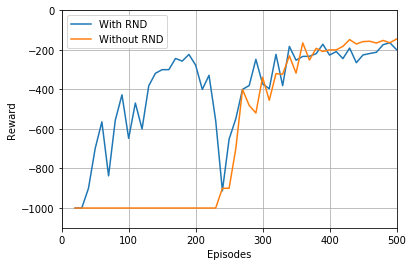

In [19]:
import matplotlib.pyplot as plt
import pickle
import numpy as np


with open("./Results/rewards-ep-500-RQN.txt", "rb") as file:
    a = pickle.load(file)  
    
with open("./Results/rewards-ep-500.txt", "rb") as file:
    b = pickle.load(file)  
    
#with open("./Results/Pong/rewards-ep-310-1.txt", "rb") as file:
    #c = pickle.load(file)  

#tot = a + b + c    

mean = []
for i in range(len(a)):
    
    if i % 10 == 0:
        mean.append(np.mean(a[i - 10 : i]))   
        
meanb = []
for i in range(len(b)):
    
    if i % 10 == 0:
        meanb.append(np.mean(b[i - 10 : i]))   
                       
    
x1 = np.array(range(1,501))
y1 = a
x2 = np.array(range(1, 51)) * 10
y2 = mean

x3 = np.array(range(1,501))
y3 = b
x4 = np.array(range(1, 51)) * 10
y4 = meanb


#plt.plot(x1,y1)
plt.plot(x2,y2, label='With RND')
#plt.plot(x3,y3)
plt.plot(x4,y4, label='Without RND')

plt.xlim(0, 500)
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.ylim(-1100, 0)
plt.legend(loc="upper left")
plt.grid(alpha=1.0)
# plt.savefig('./Images/RND_comp.png')

plt.show()